# Calculating transition states - part 4

Surface diffusion energy barriers using ASE constraints - *fixed plane* https://wiki.fysik.dtu.dk/ase/tutorials/constraints/diffusion.html

Surface diffusion energy barriers using ASE constraints - *fixed bond lengths* 

Highly mobile adsorbates (e.g. H) on surfaces in periodic calculations can cause issues during NEB due to low metastability on neighbouring adsorption sites, which means that: i) MEP length is elongated ii) Energy landscape can be very complicated. To address this one can apply constraints in ASE on bond length between specific atoms. A function has been implemented in CARMM that helps to utilise this feature.

Here let's try association, ie. reverse reaction and move Cu (atom index 19) closer and closer to the other Cu (atom index 18).

In [5]:
# BOND LENGTH SCAN - DISSOCIATION/ASSOCIATION
from carmm.build.neb.bond_length_scan import dissociation
from ase.io import read
from ase.io import Trajectory
import os
import numpy as np

# Read previously generated input structures. 
# Initial structure only used to retrieve Cu-Cu distance
slab_initial = read("slab_initial.traj")
slab_final = read ("slab_final.traj")

index1 = 18 # index of atom remaining in place (as part of molecule) 
index2 = 19 # index of atom dissociating/associationg

distance_Cu_Cu = np.linalg.norm(slab_initial[index1].position - slab_initial[index2].position)

atoms_list, distances = dissociation(slab_final, 
                                     index1, 
                                     index2, 
                                     n_steps = 7,
                                     final_distance=distance_Cu_Cu,
                                    #step_size=0.1, # only used if final_distance not set
                                    #z_bias = False # can bias the z-coordinate to towards surface or set value
                                    #group_move = None # can supply a list of atom indices to move as a group
                                     )

from ase.optimize import FIRE
from ase.calculators.emt import EMT

bl_scan = [slab_final] # list of all optimised structures will be generated

for atoms in atoms_list:
        # create naming scheme based on fixed Cu-Cu distance
        a_a_dist = np.linalg.norm(atoms[index1].position - atoms[index2].position)

        traj_name = "{:.2f}".format(a_a_dist) + ".traj"
        pckl_name = "{:.2f}".format(a_a_dist) + ".pckl"
        print(traj_name) # identify calculation in output
        
        # include functionality for restart 
        if not os.path.exists(traj_name):
            pass
        else:
            atoms = read(traj_name)
        
        atoms.set_calculator(EMT())
        
        # optimise, include max steps for safety    
        opt = FIRE(atoms, trajectory=traj_name,
                   #restart=pckl_name
                  )
        opt.run(fmax=0.05)
        
        bl_scan += [atoms]

4.23.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:42        7.333967*       0.0498
3.98.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:42        7.390691*       0.0498
3.72.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:42        7.425751*       0.0488
3.47.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:42        7.373206*       0.0464
3.22.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:42        7.277519*       0.0393
2.96.traj
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:51:43        7.202877*       0.0443
2.71.traj
      Step     Time          Energy       

In /home/igor/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igor/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igor/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/igor/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/igor/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

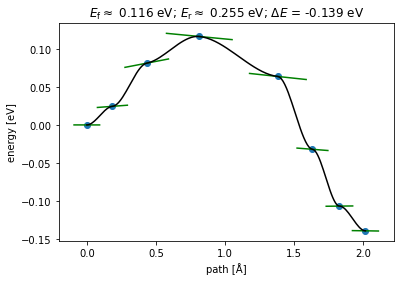

In [6]:
from ase.visualize import view
view(bl_scan)

# Use the same tools as previously to analyse the output
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

nebtools = NEBTools(bl_scan)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-bl_scan.png')

No strict control over the overall xyz coordinate shift, hence the wonky shape. Notice the energy required for reverse reaction very similar to the one extracted via other methods